#Transfer Learning

## Data

In [13]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt

IMG_WIDTH = 224
IMG_HEIGHT = 224
IMG_CHANNELS = 3

In [18]:
def read_and_decode(filename, reshape_dims):
  img = tf.io.read_file(filename)
  img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
  img = tf.image.convert_image_dtype(img, tf.float32)
  return tf.image.resize(img, reshape_dims)

def decode_csv(csv_row):
  record_defaults = ["path", "flower"]
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))

  return img, label

CLASS_NAMES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

def train_and_evaluate(batch_size=32, lrate=0.001, l1=0., l2=0., num_hidden=12):
  regularizer = tf.keras.regularizers.l1_l2(l1, l2)

  #data

  train_dataset = (tf.data.TextLineDataset(
      "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv"
  ).map(decode_csv)).batch(batch_size)

  eval_dataset = (tf.data.TextLineDataset(
      "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv"
  ).map(decode_csv)).batch(32)

  #layers

  layers = [
    #mobilenet transfer
    hub.KerasLayer(handle="https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
    input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
    trainable = False,
    name = 'mobilenet_embedding'),
    #Dense Layer
    tf.keras.layers.Dense(units=16,
                          activation = 'relu',
                          name='dense_hidden'),
    tf.keras.layers.Dense(units=len(CLASS_NAMES),
                          activation = 'softmax',
                          name='flower_prob')

  ]

  #train_prepare

  model = tf.keras.Sequential(layers, name="flower_classification")
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lrate),
                loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])

  print(model.summary)

  #train

  history = model.fit(train_dataset, validation_data = eval_dataset, epochs = 5)
  plt.plot(history.history['val_loss'], ls='dashed')
  plt.plot(history.history['loss'])

  return model

<bound method Model.summary of <keras.src.engine.sequential.Sequential object at 0x7d2506cbc820>>
Epoch 1/5
104/104 [==============================] - 186s 2s/step - loss: 0.9447 - accuracy: 0.6361 - val_loss: 0.5438 - val_accuracy: 0.8216
Epoch 2/5
104/104 [==============================] - 129s 1s/step - loss: 0.4111 - accuracy: 0.8694 - val_loss: 0.3718 - val_accuracy: 0.8838
Epoch 3/5
104/104 [==============================] - 134s 1s/step - loss: 0.2676 - accuracy: 0.9167 - val_loss: 0.3393 - val_accuracy: 0.8865
Epoch 4/5
104/104 [==============================] - 118s 1s/step - loss: 0.2008 - accuracy: 0.9412 - val_loss: 0.3296 - val_accuracy: 0.9000
Epoch 5/5
104/104 [==============================] - 108s 1s/step - loss: 0.1580 - accuracy: 0.9558 - val_loss: 0.3258 - val_accuracy: 0.9081


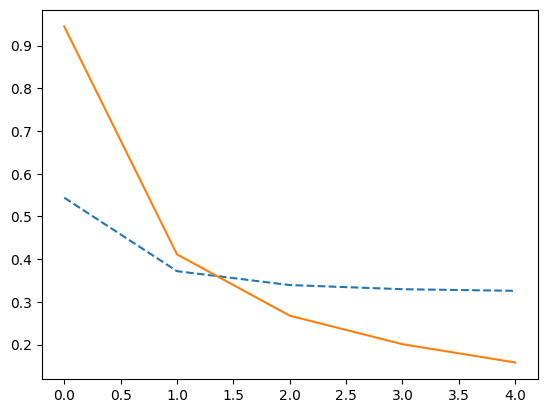

In [19]:
model = train_and_evaluate()